# CNN-based Brain Tumour Segmentation Network
## 1. Import packages
Please make sure you have all the required packages installed. If GPU is available, but you want to use CPU to train your model, make sure you add " os.environ['CUDA_VISIBLE_DEVICES'] = '-1'.
Package 'SimpleITK' is for loading the MR images, so you need to install it first.

In [2]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 2. Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which is like pixels in 2D images. Here we visualise the transverse plane (usually has a higher resolution) of some of the volumes and the corresponding segmentation maps. If the size of an MRI image is 200x230x230, it means that there are 200 slices of 230x230 images in the transverse plane.

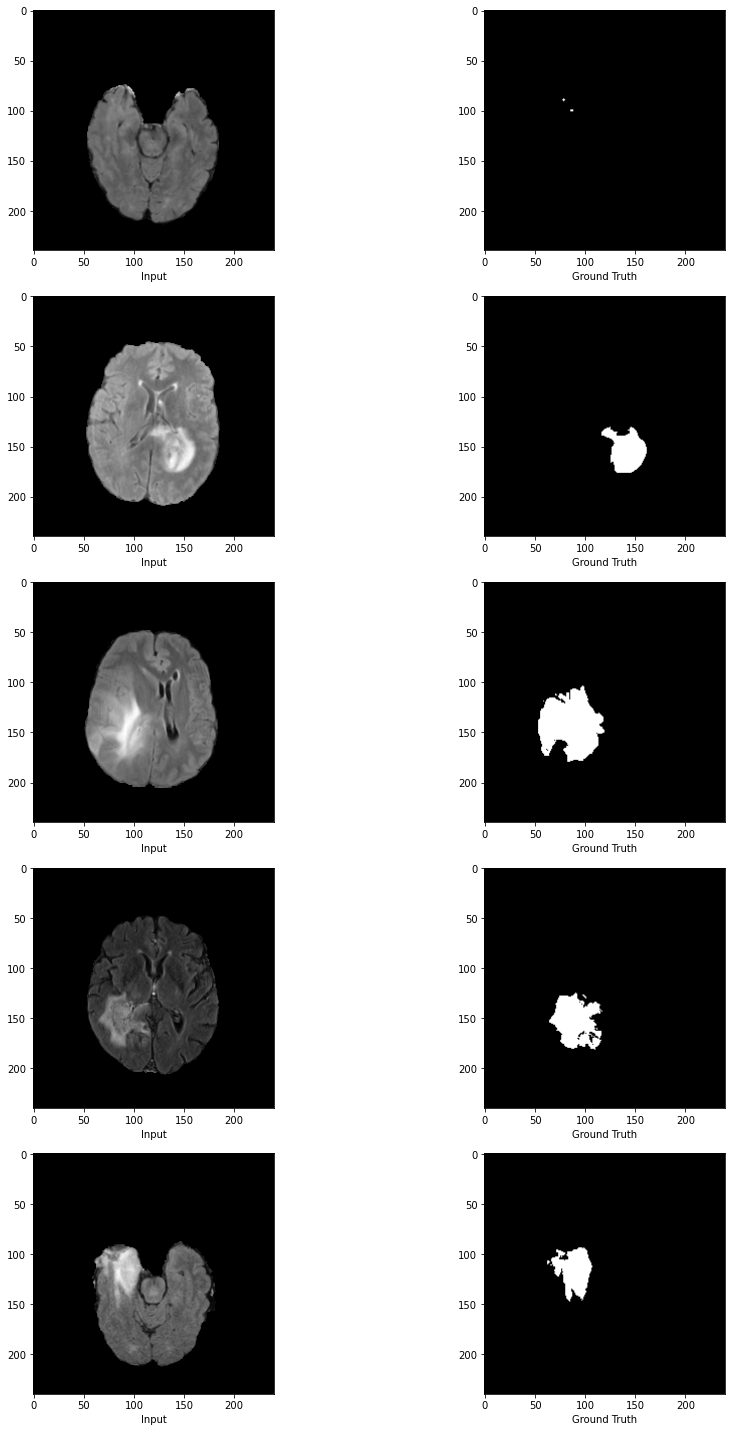

In [2]:
def plot_samples(x,n=10):
    i = n
    j = 2
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        plt.subplot(i,j,k)
        while k%2 != 0:
            plt.imshow(np.load(x[idx])[:,:,0], cmap='gray')
            plt.xlabel("Input")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(np.load(x[idx].split('_')[0]+'_seg.npy')[:,:], cmap='gray')
        plt.xlabel("Ground Truth")
        k += 1
    plt.tight_layout()
    plt.show()

img_path = 'Dataset/'
img_list = []
CLASS = 'Yes'
all_files = os.listdir(img_path + CLASS)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
img_num = len(files)
for (n, file_name) in enumerate(files):
    img = os.path.join(img_path,CLASS,file_name)
    seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
    img_list.append(img)
plot_samples(img_list, n=5)

## 3. Data preprocessing

Images in the original dataset are usually in different sizes, so sometimes we need to resize and normalise (z-score is commonly used in preprocessing the MRI images) them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods. If preprocessing methods like cropping is applied, remember to convert the segmentation result back to its original size. 

### 3.1 Normalization

In [ ]:
# Z-Score Normalization
# Z = (X - µ) / σ
def zscore(data):
    rows, cols, _ = data.shape
    media = np.zeros(shape=(cols), dtype=np.float32)
    sigma = np.zeros(shape=(cols), dtype=np.float32)
    
    for j in range(cols):
        media[j] = np.mean(data[:,j])
        sigma[j] = data[:,j].std()

    result = np.copy(data)
    for i in range(rows):
        for j in range(cols):
            result[i,j] = ((data[i,j] - media[j]) / sigma[j])
    
    return result

# Min-Max Normalization
# Z = [Xi - min(X)]/[max(X) - min(X)]
def minmax(data):
    rows, cols, _ = data.shape
    mins = np.zeros(shape=(cols), dtype=np.int32)
    maxs = np.zeros(shape=(cols), dtype=np.int32)

    for j in range(cols):
        mins[j] = np.min(data[:,j])
        maxs[j] = np.max(data[:,j])
        
    result = np.copy(data)
    for i in range(rows):
        for j in range(cols):
            result[i,j] = (data[i,j] - mins[j]) / (maxs[j] - mins[j])
    
    return result

### 3.2 Split MRI dataset into training and validation

In [6]:
# uncomment if using linux/macos
!rm -rf Train Val
!mkdir Train Val Train/Yes Train/No Val/Yes Val/No

# uncomment if using windows
# !rmdir Train Val /s /q
# !md Train Val Train\Yes Train\No Val\Yes Val\No

img_path = 'Dataset/'
train_list = []
val_list = []
for CLASS in os.listdir(img_path):
    if not CLASS.startswith('.'):
        all_files = os.listdir(img_path + CLASS)
        files = [item for item in all_files if "img" in item]
        random.shuffle(files)
        img_num = len(files)
        for (n, file_name) in enumerate(files):
            img = os.path.join(img_path,CLASS,file_name)
            seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.8*img_num:
                shutil.copy(img, os.path.join('Train/',CLASS,file_name))
                train_list.append(os.path.join('Train/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Train/',CLASS,file_name.split('_')[0]+'_seg.npy'))
            else:
                shutil.copy(img, os.path.join('Val/',CLASS,file_name))
                val_list.append(os.path.join('Val/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Val/',CLASS,file_name.split('_')[0]+'_seg.npy'))

NotADirectoryError: [WinError 267] 目录名称无效。: 'Dataset/preprocessing.py'

### 3.3 Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

In [3]:
# Get the data generator ready
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                    n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))
        Y = np.empty((self.batch_size, *self.dim, 2))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            img = np.load(ID)[:,:,0]
            img = np.expand_dims(img, axis=2)
            datagen = ImageDataGenerator(horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=15,
                        zoom_range=0.05
                        )
            datagen.fit(img)
            X[i,] = img

            # Store class
            label = np.load(ID.split('_')[0]+'_seg.npy')
            label = np.expand_dims(label, axis=2)
            label = np.concatenate(((-label)+1, label),axis=-1)
            Y[i,] = label

        return X, Y

In [ ]:
train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
img_size = (240,240)

## 4. Define a metric for the performance of the model
Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. Dice score can be also used as the loss function for training your model.

In [11]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / 
                (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

'''def focal_loss(y_true, y_pred):
    gamma=0.75
    alpha=0.25
    class_num = 2
    for i in range (class_num):  
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        
        pt_1 = tf.where(tf.equal(y_true_f, 1), y_pred_f, 
                        tf.ones_like(y_pred_f))
        pt_0 = tf.where(tf.equal(y_true_f, 0), y_pred_f, 
                        tf.zeros_like(y_pred_f))
 
        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)
    
        loss = -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss'''

def tversky(y_true, y_pred, alpha=0.7):
    smooth = 1
    class_num = 2
    for i in range (class_num):  
        y_true_pos = K.flatten(y_true[:,:,:,i])
        y_pred_pos = K.flatten(y_pred[:,:,:,i])
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1-y_pred_pos))
        false_pos = K.sum((1-y_true_pos)*y_pred_pos)
        loss = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def log_cosh_dice_loss(y_true, y_pred):
        x = dice_coef_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)


'''def focal_dice_loss(y_true,y_pred):
    alpha = 0.25
    return alpha * focal_loss(y_true,y_pred) - 
    K.log(dice_coef_loss(y_true,y_pred))'''

'def focal_dice_loss(y_true,y_pred):\n    alpha = 0.25\n    return alpha * focal_loss(y_true,y_pred) - K.log(dice_coef_loss(y_true,y_pred))'

## 5. Build self-defined model
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for the medical image segmentation task. You can build your own model or modify the UNet by changing the hyperparameters for our task. If you choose to use Keras, more information about the Keras layers including Conv2D, MaxPooling and Dropout can be found at https://keras.io/api/layers/.

In [12]:
from keras import initializers

input_size = (240,240,1)

inputs = Input(input_size)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.01))(conv5),conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.01))(conv6),conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2),padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.01))(conv7),conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',)(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.01))(conv8),conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv9)

conv10 = Conv2D(2, (1, 1), activation='relu',
                kernel_initializer=initializers.random_normal(stddev=0.01))(conv9)
conv10 = Activation('softmax')(conv10)
model = Model(inputs=[inputs], outputs=[conv10])

try:
    lr = args.lr
except:
    lr = 1e-4
model.compile(optimizer=Adam(lr=lr), loss=log_cosh_dice_loss, metrics=[dice_coef])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 240, 240, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 240, 240, 32) 9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 120, 120, 32) 0           conv2d_39[0][0]                  
_______________________________________________________________________________________

## 6. Train self-defined model
Once you defined the model and data generator, you can start training your model.

In [14]:
num_epochs = 2
earlystopping = EarlyStopping(
    monitor=dice_coef, 
    mode='max',
    patience=20
)

from keras import callbacks
# history = model.fit(
#     train_generator,
#     epochs=num_epochs,
#     validation_data=validation_generator,
#     callbacks=[earlystopping]
# )


model.fit_generator(train_generator, epochs=num_epochs,
                validation_data=validation_generator, workers=16)

Epoch 1/2
83/83 [==============================] - 1719s 21s/step - loss: 0.1782 - dice_coef: 0.3870 - val_loss: 0.0981 - val_dice_coef: 0.5499
Epoch 2/2
83/83 [==============================] - 1739s 21s/step - loss: 0.0527 - dice_coef: 0.6787 - val_loss: 0.0330 - val_dice_coef: 0.7419


## 7. Save the model
Once your model is trained, remember to save it for testing.

## 8. Run the model on the test set
After your last Q&A session, you will be given the test set. Run your model on the test set to get the segmentation results and submit your results in a .zip file. If the MRI image is named '100_fla.nii.gz', save your segmentation result as '100_seg.nii.gz'. 

In [ ]:
test_files_path = 'Dataset/test'
"""
Example of saving the prediction result (numpy array) into .nii.gz file:

sitk.save(pred, os.path.join(test_file_path,id,f'{id}_seg.nii'))

"""